In [1]:
import numpy as np

# EGS Parameters
mutual_benefit = 1.0         # mutual benefit of cooperation between equals
skeptic_cost = 0.2           # overhead of being a skeptic (education, due diligence)
grift_gain = 1.5             # payoff to a Grifter when exploiting a Mark
mark_loss = 2.0              # loss suffered by a Mark when exploited
grifter_loss = 0.5           # cost of a failed grift

A = np.array([
    [ # a grifter meets a...
        -grifter_loss, # grifter (failed scam)
        -grifter_loss, # skeptic (failed scam)
        grift_gain,   # mark (successful scam)
    ],
    # a skeptic meets a...
    [
        -skeptic_cost, # grifter (avoids scam)
         mutual_benefit - skeptic_cost, # skeptic (cooperates cautiously)
         mutual_benefit - skeptic_cost, # mark (cooperates cautiously)
    ],
    [ # a mark meets a...
        -mark_loss, # grifter (scammed)
         mutual_benefit, # skeptic (cooperation)
         mutual_benefit, # mark (cooperation)
    ],
], dtype=float)

def replicator(populations, A, delta=0.05, N=2000):
    """Return the trajectory as a 2D numpy matrix and the final population as a 1D numpy array the same shape as the population."""
    populations = np.asarray(populations, float)
    populations = populations / populations.sum()

    # initialize the trajectory with the initial conditions
    trajectory = [populations.copy()]
    
    for _ in range(N):
        fitness = A @ populations # payoff for this iteration
        average = populations @ fitness
        
        populations = populations + delta * (populations * (fitness - average))

        # avoid extinction and normalize
        populations = np.clip(populations, 1e-6, 1 + delta) 
        populations = populations / populations.sum()
        
        trajectory.append(populations.copy())
    return np.array(trajectory), populations

# Example run from a random interior point
rng = np.random.default_rng()
initial_conditions = rng.dirichlet(np.ones(3))
print("Initial conditions:", initial_conditions)


trajectory, populations_final = replicator(initial_conditions, A, N=5_000)
print("Final populations (G, S, M):", populations_final.round(4))


Initial conditions: [0.23925079 0.26097154 0.49977767]
Final populations (G, S, M): [0. 1. 0.]


In [2]:
A

array([[-0.5, -0.5,  1.5],
       [-0.2,  0.8,  0.8],
       [-2. ,  1. ,  1. ]])

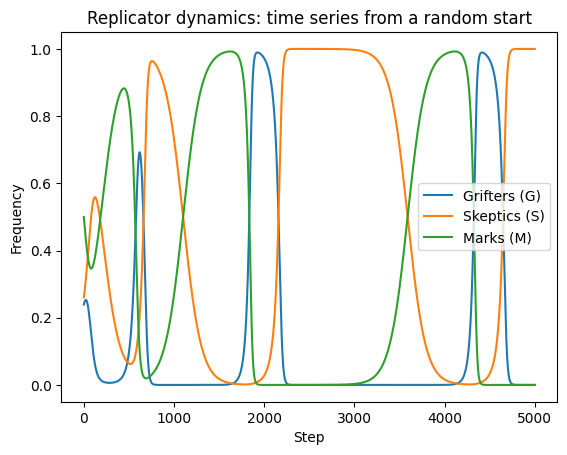

In [3]:
import matplotlib.pyplot as plt


def to_xy(p):
    # Map (x1, x2, x3) with sum=1 to equilateral triangle coordinates
    g, s, m = p[...,0], p[...,1], p[...,2]
    x = s + 0.5 * g
    y = (np.sqrt(3)/2) * g
    return np.stack([x, y], axis=-1)

def from_xy(xy):
    # Inverse map back to barycentric
    x, y = xy[...,0], xy[...,1]
    g = (2/np.sqrt(3)) * y
    s = x - 0.5 * g
    m = 1 - g - s
    P = np.stack([g, s, m], axis=-1)
    return P

def replicator_field(p, A):
    f = A @ p
    avg = p @ f
    dp = p * (f - avg)
    return dp


plt.figure()
plt.plot(trajectory[:,0], label="Grifters (G)")
plt.plot(trajectory[:,1], label="Skeptics (S)")
plt.plot(trajectory[:,2], label="Marks (M)")
plt.xlabel("Step")
plt.ylabel("Frequency")
plt.title("Replicator dynamics: time series from a random start")
plt.legend()

In [4]:
# the determined grifter/skeptic/mark cumulative payoff
(A @ trajectory.T).sum(axis=1)

array([1166.66475716, 3246.98022414, 2739.54067243])

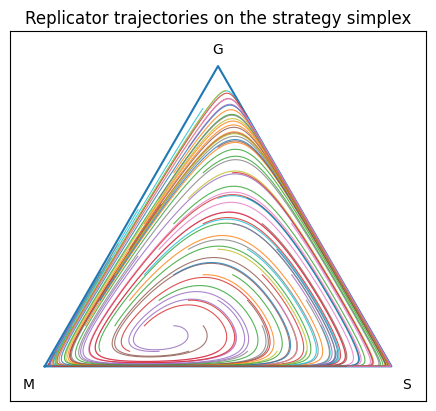

In [5]:
# --- 2) Multiple trajectories on the simplex ---
def plot_simplex_background():
    # Triangle
    tri = np.array([[0,0], [1,0], [0.5, np.sqrt(3)/2], [0,0]])
    plt.figure()
    plt.plot(tri[:,0], tri[:,1])
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, np.sqrt(3)/2 + 0.1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks([]); plt.yticks([])
    plt.title("Replicator trajectories on the strategy simplex")
    # Corner labels
    eps = 0.03
    plt.text(-eps, -eps, "M", ha="right", va="top")
    plt.text(1+eps, -eps, "S", ha="left", va="top")
    plt.text(0.5, np.sqrt(3)/2+eps, "G", ha="center", va="bottom")

plot_simplex_background()
# seed a small grid of initial points inside the simplex
seeds = []
for a in np.linspace(0.05, 0.9, 11):
    for b2 in np.linspace(0.05, 0.9, 11):
        if a + b2 < 0.95:
            g0 = a
            s0 = b2
            m0 = 1 - g0 - s0
            seeds.append([g0, s0, m0])

for p0 in seeds:
    tr = replicator(p0, A, delta=0.02)[0]
    XY = to_xy(tr)
    plt.plot(XY[:,0], XY[:,1], linewidth=0.8, alpha=0.8)

Text(0.5, 1.0, 'Replicator vector field on the simplex')

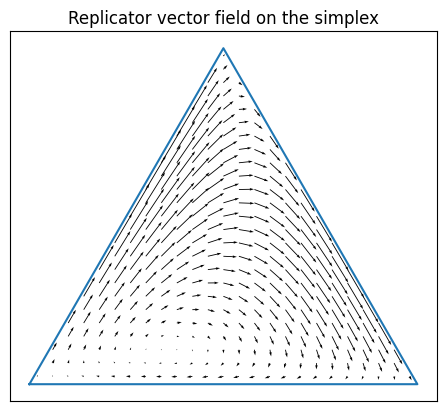

In [6]:
# --- 3) Vector field (quiver) over the simplex ---
# build a coarse grid over the triangle in (x,y), map to barycentric, compute dp/dt, project to xy
xs = np.linspace(0.02, 0.98, 25)
ys = np.linspace(0.02, np.sqrt(3)/2 - 0.02, 25)
X, Y = np.meshgrid(xs, ys)
XY = np.stack([X, Y], axis=-1)
P = from_xy(XY)

# mask points outside simplex
mask = (P[...,0] >= 0) & (P[...,1] >= 0) & (P[...,2] >= 0)
U = np.zeros_like(X); V = np.zeros_like(Y)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if mask[i,j]:
            p = P[i,j]
            dp = replicator_field(p, A)
            # small step then map movement to XY
            p_next = p + 0.02 * dp
            p_next = np.clip(p_next, 1e-12, 1.0)
            p_next /= p_next.sum()
            dxy = to_xy(p_next) - to_xy(p)
            U[i,j], V[i,j] = dxy

plt.figure()
# draw triangle boundary
tri = np.array([[0,0], [1,0], [0.5, np.sqrt(3)/2], [0,0]])
plt.plot(tri[:,0], tri[:,1])
plt.quiver(X[mask], Y[mask], U[mask], V[mask], angles='xy', scale_units='xy', scale=0.05, width=0.002)
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks([]); plt.yticks([])
plt.title("Replicator vector field on the simplex")

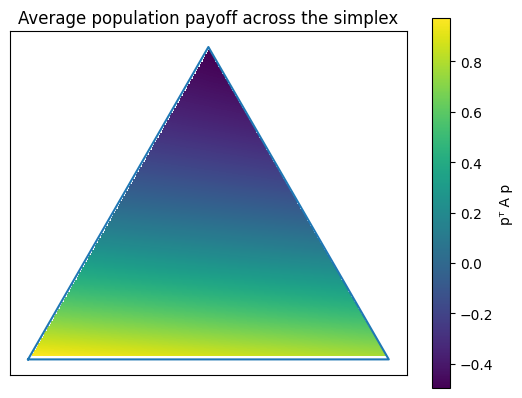

In [7]:
# --- 4) Average population payoff over simplex (heatmap) ---
# Compute average payoff p^T A p on a grid
xs = np.linspace(0.01, 0.99, 250)
ys = np.linspace(0.01, np.sqrt(3)/2 - 0.01, 250)
X, Y = np.meshgrid(xs, ys)
XY = np.stack([X, Y], axis=-1)
P = from_xy(XY)
valid = (P[...,0] >= 0) & (P[...,1] >= 0) & (P[...,2] >= 0)
avg_payoff = np.full_like(X, np.nan, dtype=float)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if valid[i,j]:
            p = P[i,j]
            f = A @ p
            avg_payoff[i,j] = p @ f

plt.figure()
plt.imshow(avg_payoff, origin='lower', extent=[xs.min(), xs.max(), ys.min(), ys.max()], aspect='equal')
plt.plot(tri[:,0], tri[:,1])
plt.xticks([]); plt.yticks([])
plt.title("Average population payoff across the simplex")
plt.colorbar(label="pᵀ A p")

In [8]:
# Jupyter interactive simplex plot for (G, S, M) replicator dynamics
# Requires: ipywidgets, numpy, matplotlib
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# ---------------------------
# Core model + utilities
# ---------------------------

H = np.sqrt(3) / 2.0  # height of equilateral simplex

def payoff_matrix(mutual_benefit, skeptic_cost, grift_gain, mark_loss, grifter_loss):
    """
    Strategy order: [Grifter (G), Skeptic (S), Mark (M)]
    Columns correspond to opponent strategy in same order.
    """

    return np.array([
        [ # a grifter meets a...
            -grifter_loss, # grifter (failed scam)
            -grifter_loss, # skeptic (failed scam)
            grift_gain,   # mark (successful scam)
        ],
        # a skeptic meets a...
        [
            -skeptic_cost, # grifter (avoids scam)
             mutual_benefit - skeptic_cost, # skeptic (cooperates cautiously)
             mutual_benefit - skeptic_cost, # mark (cooperates cautiously)
        ],
        [ # a mark meets a...
            -mark_loss, # grifter (scammed)
             mutual_benefit, # skeptic (cooperation)
             mutual_benefit, # mark (cooperation)
        ],
    ], dtype=float)
    

def replicator_field(p, A):
    """Continuous-time replicator vector field: dp/dt = p * (A p - p^T A p)."""
    p = np.asarray(p, float)
    p = np.clip(p, 1e-12, 1.0)
    p = p / p.sum()
    fitness = A @ p
    avg = p @ fitness
    return p * (fitness - avg)

def replicator(p, A, delta=0.02, N=1500):
    """Discrete-time Euler scheme for replicator dynamics (matches your signature)."""
    p = np.asarray(p, float)
    p = np.clip(p, 1e-12, 1.0)
    p = p / p.sum()
    traj = [p.copy()]
    for _ in range(N):
        dp = replicator_field(p, A)
        p = p + delta * dp
        p = np.clip(p, 1e-12, 1.0)
        p = p / p.sum()
        traj.append(p.copy())
    return np.array(traj), p

def to_xy(P):
    """
    Map barycentric (G,S,M) -> 2D:
      M -> (0,0)
      S -> (1,0)
      G -> (0.5, H)
    Accepts shape (..., 3) and returns (..., 2).
    """
    P = np.asarray(P, float)
    g = P[..., 0]
    s = P[..., 1]
    x = s + 0.5 * g
    y = H * g
    return np.stack([x, y], axis=-1)

def from_xy(XY):
    """
    Inverse map 2D -> barycentric (G,S,M) using the same vertex convention.
    Accepts shape (..., 2) and returns (..., 3).
    """
    XY = np.asarray(XY, float)
    x = XY[..., 0]
    y = XY[..., 1]
    g = y / H
    s = x - 0.5 * g
    m = 1.0 - g - s
    return np.stack([g, s, m], axis=-1)

def plot_simplex_background(ax):
    tri = np.array([[0,0], [1,0], [0.5, H], [0,0]])
    ax.plot(tri[:,0], tri[:,1], linewidth=1.2)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, H + 0.1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title("Replicator trajectories + vector field on the strategy simplex")
    eps = 0.03
    ax.text(-eps, -eps, "M", ha="right", va="top")
    ax.text(1+eps, -eps, "S", ha="left", va="top")
    ax.text(0.5, H+eps, "G", ha="center", va="bottom")

def seed_points(grid_n=11, margin=0.05, cap=0.95):
    seeds = []
    for g0 in np.linspace(margin, 0.9, grid_n):
        for s0 in np.linspace(margin, 0.9, grid_n):
            if g0 + s0 < cap:
                m0 = 1.0 - g0 - s0
                seeds.append([g0, s0, m0])
    return np.array(seeds, float)

def add_vector_field(ax, A, n=25, margin=0.02, step=0.02, scale=0.05, width=0.002):
    """
    Quiver over the simplex: sample in XY, map to barycentric, compute dp/dt,
    take a small barycentric step, and project the displacement back to XY.
    """
    xs = np.linspace(margin, 1.0 - margin, n)
    ys = np.linspace(margin, H - margin, n)
    X, Y = np.meshgrid(xs, ys)
    XY = np.stack([X, Y], axis=-1)
    P = from_xy(XY)

    mask = (P[..., 0] >= 0) & (P[..., 1] >= 0) & (P[..., 2] >= 0)

    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    # Vector computation only on masked points
    idxs = np.argwhere(mask)
    for i, j in idxs:
        p = P[i, j]
        dp = replicator_field(p, A)
        p_next = p + step * dp
        p_next = np.clip(p_next, 1e-12, 1.0)
        p_next = p_next / p_next.sum()
        dxy = to_xy(p_next) - to_xy(p)
        U[i, j] = dxy[0]
        V[i, j] = dxy[1]

    ax.quiver(X[mask], Y[mask], U[mask], V[mask],
              angles="xy", scale_units="xy", scale=scale, width=width)

# ---------------------------
# Widgets
# ---------------------------

w_b = widgets.FloatSlider(value=mutual_benefit, min=0.0, max=3.0, step=0.05,
                          description="benefit", continuous_update=False)
w_c = widgets.FloatSlider(value=skeptic_cost, min=0.0, max=2.0, step=0.05,
                          description="skeptic_cost", continuous_update=False)
w_g = widgets.FloatSlider(value=grift_gain, min=0.0, max=5.0, step=0.05,
                          description="grift_gain", continuous_update=False)
w_l = widgets.FloatSlider(value=mark_loss, min=0.0, max=5.0, step=0.05,
                          description="mark_loss", continuous_update=False)
w_k = widgets.FloatSlider(value=grifter_loss, min=0.0, max=2.0, step=0.05,
                          description="grifter_cost", continuous_update=False)

w_dt = widgets.FloatSlider(value=0.02, min=0.001, max=0.1, step=0.001,
                           description="dt", continuous_update=False)
w_T = widgets.IntSlider(value=1500, min=200, max=5000, step=100,
                        description="T", continuous_update=False)
w_grid = widgets.IntSlider(value=11, min=5, max=25, step=2,
                           description="grid_n", continuous_update=False)

# vector field controls (optional but useful)
w_vn = widgets.IntSlider(value=25, min=10, max=45, step=5,
                         description="vf_n", continuous_update=False)
w_vscale = widgets.FloatSlider(value=0.05, min=0.01, max=0.2, step=0.01,
                               description="vf_scale", continuous_update=False)

controls = widgets.VBox([
    widgets.HBox([w_b, w_c]),
    widgets.HBox([w_g, w_l]),
    widgets.HBox([w_k, w_dt]),
    widgets.HBox([w_T, w_grid]),
    widgets.HBox([w_vn, w_vscale]),
])

out = widgets.Output()

def redraw(_=None):
    with out:
        clear_output(wait=True)
        A = payoff_matrix(w_b.value, w_c.value, w_g.value, w_l.value, w_k.value)

        fig, ax = plt.subplots(figsize=(7, 6))
        plot_simplex_background(ax)

        # vector field first (so trajectories sit on top)
        add_vector_field(ax, A, n=w_vn.value, scale=w_vscale.value)

        # trajectories
        seeds = seed_points(grid_n=w_grid.value)
        for p0 in seeds:
            tr = replicator(p0, A, delta=w_dt.value, N=w_T.value)[0]
            XY = to_xy(tr)
            ax.plot(XY[:, 0], XY[:, 1], linewidth=0.8, alpha=0.8)

        # ax.text(0.02, -0.08, f"A=\n{np.array2string(A, precision=3)}",
        #         transform=ax.transAxes, fontsize=9, va="top", family="monospace")

        plt.show()

# wire up callbacks
for w in [w_b, w_c, w_g, w_l, w_k, w_dt, w_T, w_grid, w_vn, w_vscale]:
    w.observe(redraw, names="value")

display(controls, out)
redraw()


Output()